### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Barbara_ANALYTICAL_Review/Barbara_ANALYTICAL_Review"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]18:1:35 Initiating the NLP Engine
[INFO]18:1:35 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Barbara_ANALYTICAL_Review/Barbara_ANALYTICAL_Review.txt is being ported to dataframe
[INFO]18:1:35 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Barbara_ANALYTICAL_Review/Barbara_ANALYTICAL_Review.txt has been ported to dataframe
[INFO]18:1:35 Trimming data and preparing list of words
[['1,"A 1-year study of the ecological cycle of Francisella tularensis was performed in an enzootic area during an inter-epizootic period. The study was based on multiple sampling of all major constituents of the disease cycle. Seroprevalence of tularemia in the European brown hare (Lepus europaeus) population was 5.1% (10/197) with low antibody titers (1/10 and 1/20), and F. tularensis ssp. holarctica was isolated from four hares. F. tularensis was not detected in the 38 common voles (Microtus arvalis), 110 yellow-necked mice (Apodemus flavicollis), or 15 stripped field mice (Apodemus agrarius) trapped

[INFO]18:1:35 Generated word bigrams
[INFO]18:1:35 Beginning lemmatization
[INFO]18:1:36 Ending lemmatization
[INFO]18:1:37 Issued perplexity: -7.304184210663065
[INFO]18:1:37 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.015*"rodent" + 0.015*"chronic_shedd" + 0.011*"seasonal" + 0.011*"prevalence" + 0.011*"disease" + 0.011*"persistence" + 0.011*"population" + 0.009*"infection" + 0.009*"lcmv" + 0.009*"driver"'),
 (1,
  '0.014*"sample" + 0.012*"wild" + 0.011*"japanese" + 0.010*"positive" + 0.010*"tick" + 0.010*"rodent" + 0.009*"disease" + 0.009*"animal" + 0.009*"tularensis" + 0.008*"dqb"'),
 (2,
  '0.064*"plague" + 0.029*"flea" + 0.016*"prairie_dogs" + 0.016*"colony" + 0.015*"rodent" + 0.014*"disease" + 0.012*"prairie_dog" + 0.011*"black_tail" + 0.010*"increase" + 0.009*"epizootic"'),
 (3,
  '0.016*"disease" + 0.014*"mouse" + 0.013*"male" + 0.010*"individual" + 0.009*"pva" + 0.009*"model" + 0.008*"mammal" + 0.008*"number" + 0.008*"human" + 0.008*"female"'),
 (4,
  '0.026*"host" + 0.011*"wild" + 0.010*"community" + 0.009*"condition" + 0.008*"individual" + 0.008*"human" + 0.008*"bacterial" + 0.008*"parasite" + 0.008*"leptospira" + 0.007*"animal"'),
 (5,
  '0.014*"mammal" + 0.012*"host" + 0.009*"se

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('host', 0.06097560975609756),
   ('pathogen', 0.056402439024390245),
   ('ecology', 0.042682926829268296),
   ('bat', 0.038109756097560975),
   ('range', 0.025914634146341462),
   ('important', 0.022865853658536585),
   ('collect', 0.021341463414634148),
   ('datum', 0.021341463414634148),
   ('detect', 0.019817073170731708),
   ('sample', 0.018292682926829267)]),
 (1,
  [('year', 0.04779411764705882),
   ('vole', 0.03860294117647059),
   ('disease', 0.034926470588235295),
   ('forest', 0.025735294117647058),
   ('seroprevalence', 0.025735294117647058),
   ('wildlife', 0.022058823529411766),
   ('male', 0.022058823529411766),
   ('individual', 0.01838235294117647),
   ('summer', 0.01838235294117647),
   ('squirrel', 0.016544117647058824)]),
 (3,
  [('individual', 0.04070796460176991),
   ('parasite', 0.03185840707964602),
   ('immune', 0.03185840707964602),
   ('role', 0.024778761061946902),
   ('large', 0.024778761061946902),
   ('condition', 0.023008849557522124),
   ('syste

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.36340456239133734


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

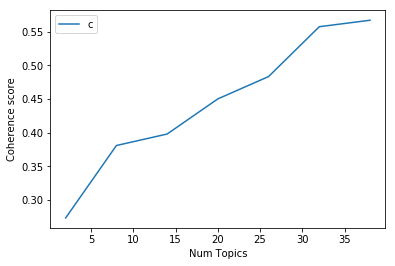

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.061*"host" + 0.056*"pathogen" + 0.043*"ecology" + 0.038*"bat" + '
  '0.026*"range" + 0.023*"important" + 0.021*"collect" + 0.021*"datum" + '
  '0.020*"detect" + 0.018*"sample" + 0.015*"distribution" + 0.014*"follow" + '
  '0.014*"lack" + 0.014*"zoonotic" + 0.014*"region" + 0.012*"knowledge" + '
  '0.011*"sequence" + 0.011*"compare" + 0.011*"leptospira" + 0.011*"analyse" + '
  '0.011*"presence" + 0.009*"agent" + 0.009*"great" + 0.009*"europe" + '
  '0.009*"germany" + 0.009*"form" + 0.009*"myotis" + 0.008*"local" + '
  '0.008*"order" + 0.008*"history" + 0.008*"specificity" + '
  '0.008*"evolutionary" + 0.008*"information" + 0.008*"molecular" + '
  '0.006*"geographical" + 0.006*"elsevier" + 0.006*"fragment" + '
  '0.006*"evolution" + 0.006*"screen" + 0.006*"genetic"'),
 (1,
  '0.048*"year" + 0.039*"vole" + 0.035*"disease" + 0.026*"forest" + '
  '0.026*"seroprevalence" + 0.022*"wildlife" + 0.022*"male" + '
  '0.018*"individual" + 0.018*"summer" + 0.017*"squirrel" + 0.015*"bank" +

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.4342,"infection, tularensis, rodent, tick, reservoir...","[1,""A 1-year study of the ecological cycle of ..."
1,1,8.0,0.4429,"rate, risk, disease, associate, factor, captur...","[1,""A seasonal rodent-borne disease surveillan..."
2,2,11.0,0.4844,"human, transmission, vector, potential, increa...","[1,""Alterations in transmission of vector-born..."
3,3,9.0,0.4264,"infection, tularensis, rodent, tick, reservoir...","[1,""Although the importance of rodents as rese..."
4,4,5.0,0.5350,"mammal, host, rat, site, tick, significantly, ...","[1,""Amblyomma macula turn Koch is the primary ..."
5,5,1.0,0.1731,"year, vole, disease, forest, seroprevalence, w...","[1,""An inventory and monitoring program for sp..."
6,6,2.0,0.4858,"virus, mammal, wild, bear, isolate, test, anim...","[1,""Avian influenza (AI) viruses primarily cir..."
7,7,11.0,0.4522,"human, transmission, vector, potential, increa...","[1,""Background: Aedes albopictus is an invasiv..."
8,8,11.0,0.4786,"human, transmission, vector, potential, increa...","[1,""Background: Mosquito-borne pathogens are o..."
9,9,6.0,0.3469,"disease, population, include, epidemic, dynami...","[1,""Background: The two most reported mosquito..."


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"infection, tularensis, rodent, tick, reservoir...",4.0,0.0645
1,8.0,"rate, risk, disease, associate, factor, captur...",6.0,0.0968
2,11.0,"human, transmission, vector, potential, increa...",6.0,0.0968
3,9.0,"infection, tularensis, rodent, tick, reservoir...",4.0,0.0645
4,5.0,"mammal, host, rat, site, tick, significantly, ...",8.0,0.1290
5,1.0,"year, vole, disease, forest, seroprevalence, w...",5.0,0.0806
6,2.0,"virus, mammal, wild, bear, isolate, test, anim...",4.0,0.0645
7,11.0,"human, transmission, vector, potential, increa...",5.0,0.0806
8,11.0,"human, transmission, vector, potential, increa...",3.0,0.0484
9,6.0,"disease, population, include, epidemic, dynami...",8.0,0.1290


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     13.808525        1       1  0.016308  0.002710
5      13.114516        1       2 -0.067485 -0.078402
9      12.966455        1       3  0.114702 -0.062216
4       9.701368        1       4 -0.093923 -0.092344
6       9.547828        1       5 -0.061927  0.044075
1       8.102085        1       6 -0.099226  0.034380
2       8.097153        1       7  0.132147  0.086445
3       6.042562        1       8  0.086677 -0.037372
7       5.007113        1       9 -0.046310  0.120821
0       4.937611        1      10  0.055136 -0.060554
8       4.900262        1      11 -0.012579  0.092956
10      3.774515        1      12 -0.023520 -0.050500, topic_info=     Category       Freq          Term      Total  loglift  logprob
1392  Default  42.000000        plague  42.000000  30.0000  30.0000
1288  Default  29.000000          tick  29.000000  29.0000  29.0000
262   Default  22.000000          flea  22.000000  28.0000  28.0000
1509  Default  68.000000          host  68.000000  27.0000  27.0000
1779  Default  22.000000      mosquito  22.000000  26.0000  26.0000
1819  Default  33.000000     infection  33.000000  25.0000  25.0000
1346  Default  13.000000        immune  13.000000  24.0000  24.0000
1517  Default  22.000000    tularensis  22.000000  23.0000  23.0000
1362  Default  33.000000        rodent  33.000000  22.0000  22.0000
11    Default   7.000000      telomere   7.000000  21.0000  21.0000
1320  Default  17.000000           rat  17.000000  20.0000  20.0000
326   Default  34.000000          wild  34.000000  19.0000  19.0000
1621  Default  11.000000  prairie_dogs  11.000000  18.0000  18.0000
1327  Default  26.000000          bear  26.000000  17.0000  17.0000
123   Default  25.000000    individual  25.000000  16.0000  16.0000
1032  Default  12.000000     influenza  12.000000  15.0000  15.0000
1169  Default   7.000000          cell   7.000000  14.0000  14.0000
1754  Default   9.000000         nymph   9.000000  13.0000  13.0000
1719  Default  18.000000        colony  18.000000  12.0000  12.0000
1290  Default  33.000000  transmission  33.000000  11.0000  11.0000
1405  Default  15.000000       isolate  15.000000  10.0000  10.0000
1934  Default  16.000000         mouse  16.000000   9.0000   9.0000
399   Default  45.000000         virus  45.000000   8.0000   8.0000
706   Default  16.000000      epidemic  16.000000   7.0000   7.0000
1921  Default  17.000000          vole  17.000000   6.0000   6.0000
1166  Default  16.000000           rrv  16.000000   5.0000   5.0000
1751  Default  21.000000          rate  21.000000   4.0000   4.0000
699   Default   6.000000           age   6.000000   3.0000   3.0000
1180  Default  39.000000    population  39.000000   2.0000   2.0000
890   Default   7.000000        length   7.000000   1.0000   1.0000
...       ...        ...           ...        ...      ...      ...
1346  Topic12   6.207686        immune  13.604464   2.4923  -3.8324
976   Topic12   3.744650       decline   8.370885   2.4725  -4.3379
1315  Topic12   1.282254        badger   2.794472   2.4979  -5.4096
803   Topic12   1.896536       related   4.315424   2.4547  -5.0182
755   Topic12   1.267207  chemotherapy   2.798395   2.4847  -5.4214
372   Topic12   1.281872         short   3.367030   2.3112  -5.4099
1751  Topic12   4.630595          rate  21.512087   1.7410  -4.1255
760   Topic12   1.791806      european   5.787620   2.1044  -5.0750
2102  Topic12   1.899234      evidence   7.139314   1.9527  -5.0168
918   Topic12   1.234640      serology   3.629285   2.1986  -5.4474
1633  Topic12   1.217181      probably   3.664774   2.1747  -5.4617
1819  Topic12   4.615838     infection  33.013889   1.3095  -4.1287
123   Topic12   3.744480    individual  25.301157   1.3663  -4.3379
877   Topic12   1.899061        relate   8.142466   1.8212  -5.0169
693   Topic12   2.242337          role  11.053644   1.6817  -4.8507
1180 

In [38]:
import dill

In [39]:
dill.dump_session('databases/BarbaraDataReview.db')